# Исходные данные

## Теория 

Даны данные с параметрами добычи и очистки. 

Технологический процесс золотодобычи:
1. Флотация (обогащение)
2. Очистка 1
3. Очистка 2

*Отвальные хвосты - остатки продукта с низкой концентрацией ценных металлов*

**Технологический процесс**

 - Rougher feed — исходное сырье
 - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).

 - Rougher process (англ. «грубый процесс») — флотация
 - Rougher tails — отвальные хвосты
 - Float banks — флотационная установка
 - Cleaner process — очистка
 - Rougher Au — черновой концентрат золота
 - Final Au — финальный концентрат золота
 
 
 **Параметры этапов**
 
 - air amount — объём воздуха
 - fluid levels — уровень жидкости
 - feed size — размер гранул сырья
 - feed rate — скорость подачи

## Формула эффективности обогащения 

<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg'>

 - C — доля золота в концентрате после флотации/очистки;
 - F — доля золота в сырье/концентрате до флотации/очистки;
 - T — доля золота в отвальных хвостах после флотации/очистки.

## Обозначения в данных

Наименование признаков - 
**[этап].[тип_параметра].[название_параметра]**

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
 - rougher — флотация
 - primary_cleaner — первичная очистка
 - secondary_cleaner — вторичная очистка
 - final — финальные характеристики
 
Возможные значения для блока [тип_параметра]:
 - input — параметры сырья
 - output — параметры продукта
 - state — параметры, характеризующие текущее состояние этапа
 - calculation — расчётные характеристики

# Постановка задачи

Подготовить прототип модели машинного обучения для эффективной работы промышленных предприятий.
 - Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 
 - Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Ход работы:

 - Подготовить данные
 - Провести анализ данных
 - Построить и обучить модель.

Конечная метрика качества — sMAPE (симметричное среднее абсолютное процентное отклонение) включит в себя эффективность обогащения чернового концентрата *rougher.output.recovery* и финального концентрата *final.output.recovery*

<img src='https://pictures.s3.yandex.net/resources/smape_1576239058.jpg'>

<img src='https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg'>

# Обзор данных 

In [1]:
# импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# открытие файлов

try:
    full_data = pd.read_csv('gold_recovery_full_new.csv')
    train_data = pd.read_csv('gold_recovery_train_new.csv')
    test_data = pd.read_csv('gold_recovery_test_new.csv')
except:
    full_data = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
    train_data = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    test_data = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')

In [3]:
# обзор данных

full_data.head().T

,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647


In [4]:
print('Размерность датасетов\n')
print('Полный набор данных', full_data.shape)
print('Обучающий набор данных', train_data.shape)
print('Тестовый набор данных', test_data.shape)

Размерность датасетов

Полный набор данных (19439, 87)
Обучающий набор данных (14149, 87)
Тестовый набор данных (5290, 53)


В тестовом наборе данных колонок почти в 2 раза меньше, чем в полном и обучающем наборах.
Посмотрим на все колонки данных

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

<div class="alert alert-block alert-warning">

В тестовом наборе данных отсутствуют финальные данные и данные с параметрами продукта - скорее всего, они в совокупности являются нашим целевым признаком, либо прямо коррелируют с ним

## Корреляция 

In [7]:
# посмотрим на корреляцию важного целевого признака - общей эффективности
# выведем их в порядке убывания
    
full_data.corr()['final.output.recovery'].sort_values(ascending=False)

final.output.recovery                 1.000000
primary_cleaner.input.sulfate         0.366954
rougher.input.floatbank11_xanthate    0.328231
rougher.input.floatbank10_xanthate    0.328066
rougher.output.recovery               0.327059
                                        ...   
rougher.output.tail_au               -0.313320
rougher.output.tail_pb               -0.317056
secondary_cleaner.output.tail_au     -0.334696
primary_cleaner.output.tail_au       -0.391106
final.output.tail_au                 -0.409200
Name: final.output.recovery, Length: 86, dtype: float64

Явной корреляции с целевым признаком нет. Посмотрим на корреляцию обучающих признаков из тестового набора данных.

Так как признаков много, напишем функцию, которая в конечном счете вернет нам список самых коррелирующих признаков

In [8]:
def corr_list(data, coefficient): # функция примет датасет и нужный нам коэффициент корреляции, который нельзя превышать
    
    cor = [] # список списков, в котором будут храниться названия коррелирующих колонок  
    for row in data.corr().index:
        l = data.corr().loc[data.corr()[row]>abs(coefficient), row]   
        l = l.drop([row]) # исключим колонку с тем же названием, по которой сейчас итерируемся (их корреляция 1)
        l = list(filter(None, l.index))  # фильтрация без функции уберет все пустые значения
        cor.append(l) # добавляем полученный список названий корерилующих колонок
        
    # список списков преобразуем в один список, чтобы затем убрать дублирующие значения
    cor_list = [] # общий список коррелирующих колонок 
    for value in cor:
        cor_list.extend(value)
        
    # пройдем циклом по всем значениям полученного списка и сохраним только уникальные
    final_cor = [] # список коррелирующих колонок, которые надо будет удалить
    for value in cor_list:
        if value not in final_cor:
            final_cor.append(value) 
            
    return final_cor       

In [9]:
# выведем список коррелирующих колонок обучающего набора данных

train_cor = corr_list(train_data, 0.95)
print('Кол-во коррелирующих признаков обучающей выборки выше 0.95 по модулю -', len(train_cor), 'из', train_data.shape[1])

Кол-во коррелирующих признаков обучающей выборки выше 0.95 по модулю - 10 из 87


In [10]:
# выведем список коррелирующих колонок полного набора данных

full_cor = corr_list(full_data, 0.95)
print('Кол-во коррелирующих признаков всех данных выше 0.95 по модулю -', len(full_cor), 'из', full_data.shape[1])

Кол-во коррелирующих признаков всех данных выше 0.95 по модулю - 9 из 87


In [11]:
# выведем список коррелирующих колонок тестового набора данных

test_cor = corr_list(test_data, 0.95)
print('Кол-во коррелирующих признаков всех данных выше 0.95 по модулю -', len(test_cor), 'из', test_data.shape[1])

Кол-во коррелирующих признаков всех данных выше 0.95 по модулю - 11 из 53


Заметно, что в тестовом наборе данных коррелирующих колонок больше - выведем их

In [12]:
# оценим, какие колонки из коррелирующих есть в тестовом наборе, но нет в обучающем

for row in test_cor:
    if row not in train_cor:
        print(row)

primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_a_air
rougher.state.floatbank10_c_air
rougher.state.floatbank10_b_air
rougher.state.floatbank10_d_air


<div class="alert alert-block alert-warning">
    
В тестовом наборе данных выделились дополнительные коррелирующие колонки (их больше, чем в обучающем наборе) - однако корреляция составляет почти единицу (0.95) - поэтому в дальнейшем эти колонки придется удалить для корректной работы модели.

<div class="alert alert-block alert-info">

**Итог**

Проведен первичный обзор данных и оценка корреляции.

Кроме того,

 - Необходимо проверить расчет эффективности обогащения - т.к это одно из главных значений для расчета итоговой метрики качества
 
 - Необходима работа с пропусками
 - Необходимо проверить дубликаты
 
 - Необходимо исключить колонки, которые будут мешать работе модели

# Расчет эффективности обогащения

In [13]:
# эффективность обогащения находится в колонке rougher.output.recovery

train_data['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

Для рассчета эффективности нам необходимы доли золота концентрата до и после очистки, а также в хвостах.

Рассчитаем эффективность для обучающей выборки.

Формула расчета выглядит как **C(F-T) / F(C-T)**

 - C - ['rougher.output.concentrate_au'] *доля золота в концентрате после флотации*
 - F - ['rougher.input.feed_au'] *доля золота в сырье/концентрате до флотации*
 - T - ['rougher.output.tail_au'] *доля золота в отвальных хвостах после флотации*

In [14]:
# напишем функцию для упрощения работы

def recovery(C,F,T):
    rec = (C*(F-T)) / (F*(C-T))
    return rec*100

In [15]:
# вычислим эффективность очистки для обучающей выборки

train_rec = recovery(train_data['rougher.output.concentrate_au'], 
                     train_data['rougher.input.feed_au'], 
                     train_data['rougher.output.tail_au'])

In [16]:
# сравним наши вычисления с колонкой rougher.output.recovery

print('Медиана эффективности обучающей выборки -', train_data['rougher.output.recovery'].median())
print('Медиана эффективности дополнительных вычислений -', train_rec.median())

print('\nСтатистики обучащей выборки\n', train_data['rougher.output.recovery'].describe())
print('\nСтатистики дополнительных вычислений\n', train_rec.describe())

Медиана эффективности обучающей выборки - 85.2994620986978
Медиана эффективности дополнительных вычислений - 85.29946209869779

Статистики обучащей выборки
 count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

Статистики дополнительных вычислений
 count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64


In [17]:
# вычислим среднюю абсолютную ошибку MAE

mae = mean_absolute_error(train_data['rougher.output.recovery'], train_rec)
print('Средняя абсолютная ошибка -', mae)
print('Целочисленный формат', int(mae))

Средняя абсолютная ошибка - 9.73512347450521e-15
Целочисленный формат 0


<div class="alert alert-block alert-info">

**Вывод** 

Эффективность расчитана правильно - медиана и статистики равны (погрешность минимальна); средняя абсолютная ошибка также минмальна (формально равна нулю)

# Предобработка

 - Необходимо исключить колонки, мешающие работе модели
 - Необходимо проверить дубликаты
 - Необходима работа с пропусками
 - Для работы регрессии необходимо масштабирование признаков

## Полный набор данных

In [18]:
# изменим формат даты на datetime

full_data['date'] = pd.to_datetime(full_data['date'], format='%Y-%m-%dT%H:%M:%S')

In [19]:
# проверим полные дубликаты

full_data.duplicated().sum()

0

In [20]:
# неявные дубликаты проверим по колонке даты - если они совпадают, то перед нами дубликат
# если проход по колонке date вернет нам True, увеличим счетчик дубликатов на 1

count=0
for d in full_data.duplicated(subset=['date'], keep=False):
    if d == True:
        count+=1
        
print(count)        

0


In [21]:
# удалим коррелирующие колонки, список которых ранее получили [full_cor]

full_data = full_data.drop(columns=full_cor, axis=1)

In [22]:
# пропуски в данных

full_data.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 78, dtype: int64

В элементе sol самое большое кол-во пропусков в совокупности - особенно после вторичной очистки. Для нас он не является значимым, поэтому колонки с ним также можно удалить.

In [23]:
# удаляем колонки с элементом sol

sol = ['final.output.concentrate_sol',
       'final.output.tail_sol',
       'primary_cleaner.output.concentrate_sol',
       'rougher.input.feed_sol',
       'rougher.output.tail_sol',
       'secondary_cleaner.output.tail_sol']

full_data = full_data.drop(columns=sol, axis=1)

In [24]:
# остальные пропуски заполним предудущим значением - т.к все данные индетированы по дате и времени
# напишем функцию для ее дальшейшего применения к оставшимся датасетам

def fill_prev(data):
    full_column = list(data.iloc[:0])         # сохраним в список все колонки датасета
    for column in full_column:                # циклом пройдем по каждой колонке и заполним пропуски в ней предыдущим значением 
        data[column].fillna(method='ffill', inplace=True)                 
    return data    

In [25]:
full_data = fill_prev(full_data)

In [26]:
# проверим датасет на наличие пропусков

full_data.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 72, dtype: int64

In [27]:
print('Окончательный размер полного набора данных -', full_data.shape)

Окончательный размер полного набора данных - (19439, 72)


Повторим те же действия для двух оставшихся датасетов

## Обучающая выборка 

In [28]:
# дубликаты

train_data.duplicated().sum()

0

In [29]:
# удаление колонки date
# удаление коррелирующих колонок списка train_cor
# удаление колонок элемента sol

train_data = train_data.drop(['date'], axis=1)
train_data = train_data.drop(columns=train_cor, axis=1)
train_data = train_data.drop(columns=sol, axis=1)

In [30]:
# пропуски данных - заполнение предыдущим значением

train_data = fill_prev(train_data)
train_data.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_au                   0
final.output.recovery                         0
final.output.tail_ag                          0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 70, dtype: int64

In [31]:
print('Окончательный размер обучающего набора данных -', train_data.shape)

Окончательный размер обучающего набора данных - (14149, 70)


## Тестовая выборка

In [32]:
# изменим формат даты на datetime

test_data['date'] = pd.to_datetime(test_data['date'], format='%Y-%m-%dT%H:%M:%S')

In [33]:
# дубликаты

test_data.duplicated().sum()

0

In [34]:
# удаление коррелирующих колонок списка test_cor

test_data = test_data.drop(columns=test_cor, axis=1)

In [35]:
# удалим колонки с элементом sol, как и в предыдущих датасетах

for row in list(test_data.iloc[:0]):
    if 'sol' in row:
        print(row)
        
test_data = test_data.drop(['rougher.input.feed_sol'], axis=1)        

rougher.input.feed_sol


In [36]:
# пропуски данных - заполнение предыдущим значением

test_data = fill_prev(test_data)
test_data.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate             0
rougher.input.floatbank11_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level       

In [37]:
print('Окончательный размер тестового набора данных -', test_data.shape)

Окончательный размер тестового набора данных - (5290, 41)


# Анализ данных

## Концентрация металлов полного набора данных 

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [38]:
# для удобства создадим списки по каждому металлу, чтобы затем по ним построить гистограммы

#AU золото
gold = ['rougher.input.feed_au', 
        'rougher.output.concentrate_au', 
        'primary_cleaner.output.concentrate_au', 
        'final.output.concentrate_au']

#AG серебро
silver = ['rougher.input.feed_ag', 
          'rougher.output.concentrate_ag', 
          'primary_cleaner.output.concentrate_ag',
          'final.output.concentrate_ag'] 

#PB свинец
plumbum = ['rougher.input.feed_pb', 
           'rougher.output.concentrate_pb',
           'primary_cleaner.output.concentrate_pb',
           'final.output.concentrate_pb']        

Построим гистограммы

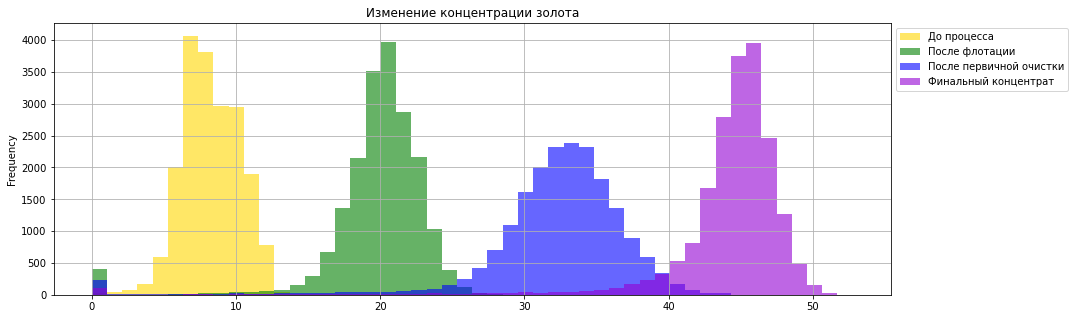

In [39]:
color=['gold', 'green', 'blue', 'darkviolet']

full_data[gold].plot(kind='hist', 
                     title='Изменение концентрации золота',
                     bins=50,
                     figsize=(15,5),
                     grid=True,
                     alpha=0.6,
                     color=color
                    )
plt.legend(['До процесса', 'После флотации', 'После первичной очистки', 'Финальный концентрат'], bbox_to_anchor=(1,1))

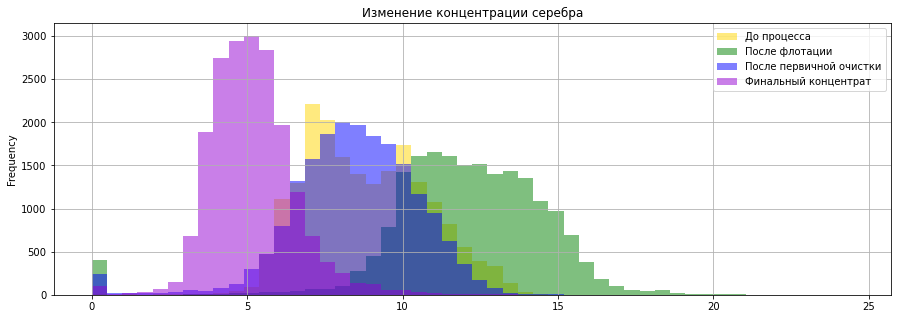

In [40]:
color=['gold', 'green', 'blue', 'darkviolet']

full_data[silver].plot(kind='hist', 
                     title='Изменение концентрации серебра',
                     bins=50,
                     figsize=(15,5),
                     grid=True,
                     alpha=0.5,
                     color=color
                    )
plt.legend(['До процесса', 'После флотации', 'После первичной очистки', 'Финальный концентрат'])

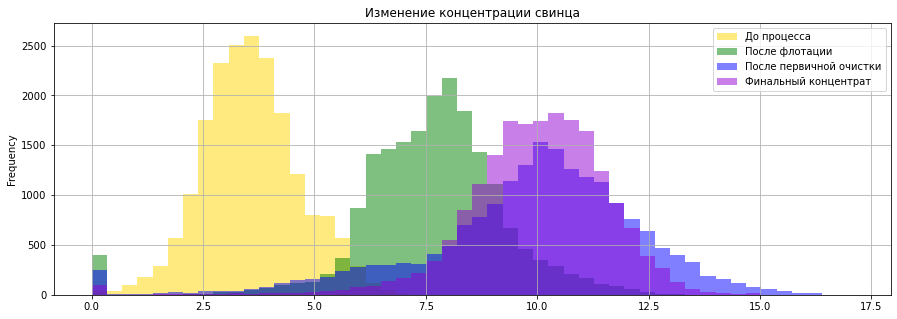

In [41]:
color=['gold', 'green', 'blue', 'darkviolet']

full_data[plumbum].plot(kind='hist', 
                     title='Изменение концентрации свинца',
                     bins=50,
                     figsize=(15,5),
                     grid=True,
                     alpha=0.5,
                     color=color
                    )
plt.legend(['До процесса', 'После флотации', 'После первичной очистки', 'Финальный концентрат'])

<div class="alert alert-block alert-info">  
    
**Вывод**

Оценка гистограмм изменения концентрации металлов говорит нам о следующем:    
 - Вполне ожидаемо, что концентрация золота стабильно увеличивается с каждым этапом обработки - от минимума, сосредоточенного в районе до 10 ед, до максимума - от 40 до 50 ед.
 - особенность серебра - после флотации этот металл повышает свою концентрацию почти до 15 ед, но затем стабильно снижает ее вплоть до 3-7 ед.
 - Свинец показывает в общем сходную динамику с золотом - его концентрация повышается, но не так выраженно и в более скромном масштабе - его максимум сосредоточен в районе 10 ед. Кроме того, повышение концентрации наблюдается только до этапа первичной очистки - затем она перестает расти.

## Распределение размера гранул сырья обучающей и тестовой выборки 

Посмотрим на распределение параметров сырья до первого этапа флотации - по основным метеллам

In [42]:
# Напишем функцию, которая затем для каждого датасета выведет нужный нам список колонок

def feed_size(data):
    
    list_row = []                          # список будет хранить список нужных колонок
    for row in list(data.iloc[:0]):
        if 'feed_size' in row:             # нужные нам колонки с размером гранул - "feed_size"
            list_row.append(row)
            
    return list_row                        # возвращаем полученный список

In [43]:
train_row = feed_size(train_data)          # применяем функцию к обучающему набору данных
        
test_row = feed_size(test_data)            # применяем функцию к тестовому набору данны

Построим гистограммы

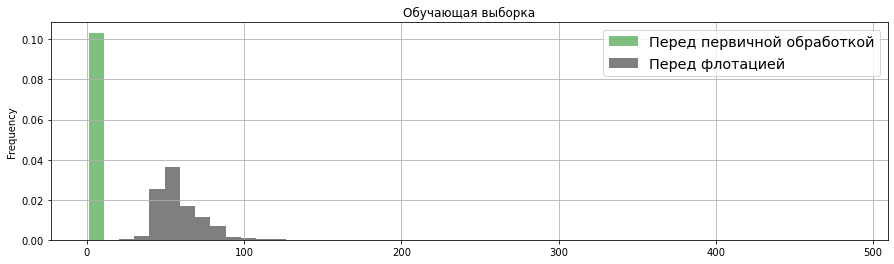

In [44]:
color=['green', 'black']

train_data[test_row].plot(kind='hist',
                          title='Обучающая выборка',
                          density=True,
                          bins=50,
                          grid=True,
                          figsize=(15,4),
                          alpha=0.5,
                          color=color
                         )

plt.legend(['Перед первичной обработкой','Перед флотацией'], fontsize='x-large')

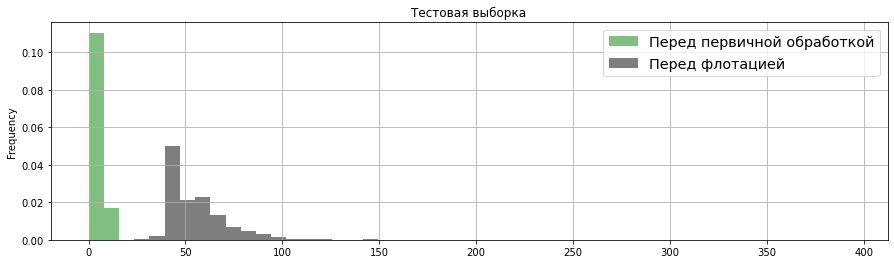

In [45]:
color=['green', 'black']

test_data[test_row].plot(kind='hist',
                           title='Тестовая выборка',
                           density=True,
                           bins=50,
                           grid=True,
                           figsize=(15,4),
                           alpha=0.5,
                           color=color
                          )

plt.legend(['Перед первичной обработкой','Перед флотацией'], fontsize='x-large')

<div class="alert alert-block alert-info">
    
**Вывод**
    
Распределение гранул в обеих выборках имеет сходный характер - поэтому при обучении и тесте выводы не должны отличаться - оценка модели будет верной.

## Суммарная концентрация веществ на разных стадиях

Посчитаем общую концентрацию веществ в сырье, черновом и финальном концентратах. 

In [46]:
# сохраним нужные нам колонки для оценки в списки

raw = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']

after_rougher = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']

final_product = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']

Концентрация веществ в сырье

rougher.input.feed_au    160684.665932
rougher.input.feed_ag    170964.594230
rougher.input.feed_pb     69690.675538
dtype: float64


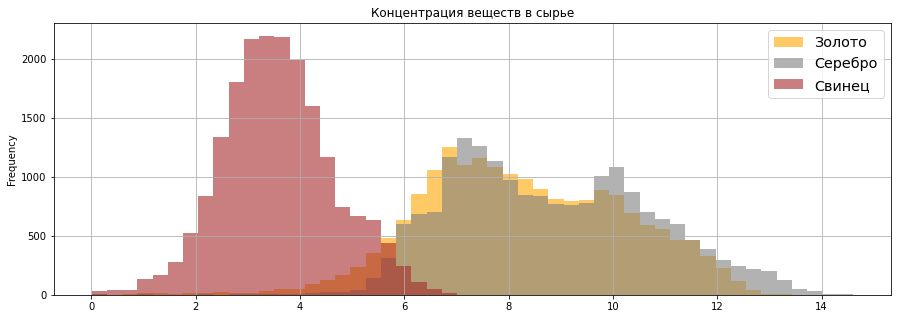

In [47]:
print('Концентрация веществ в сырье\n')
print(full_data[raw].sum())

color=['orange', 'grey', 'brown']
full_data[raw].plot(kind='hist',
                    title='Концентрация веществ в сырье',
                    bins=50,
                    grid=True,
                    figsize=(15,5),
                    alpha=0.6,
                    color=color
                   )

plt.legend(['Золото', 'Серебро', 'Свинец'], fontsize='x-large')

Концентрация веществ в черновом концентрате

rougher.output.concentrate_au    275055.963640
rougher.output.concentrate_ag    166615.968436
rougher.output.concentrate_pb    108445.785179
dtype: float64


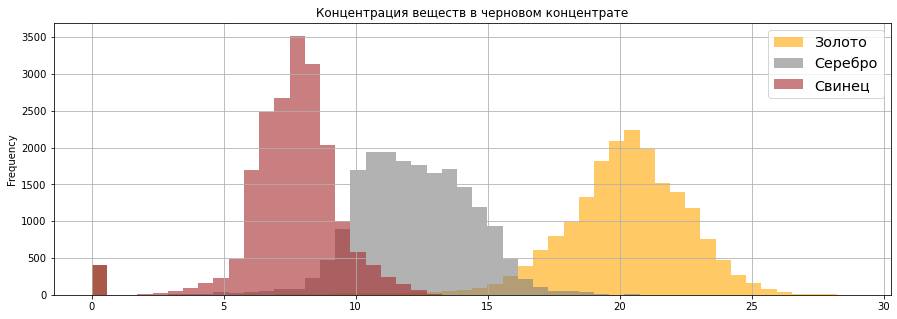

In [48]:
print('Концентрация веществ в черновом концентрате\n')
print(train_data[after_rougher].sum())

color=['orange', 'grey', 'brown']
full_data[after_rougher].plot(kind='hist',
                              title='Концентрация веществ в черновом концентрате',
                              bins=50,
                              grid=True,
                              figsize=(15,5),
                              alpha=0.6,
                              color=color
                             )

plt.legend(['Золото', 'Серебро', 'Свинец'], fontsize='x-large')

Концентрация веществ в финальном концентрате

final.output.concentrate_au    622609.647646
final.output.concentrate_ag     72753.039166
final.output.concentrate_pb    143369.662930
dtype: float64


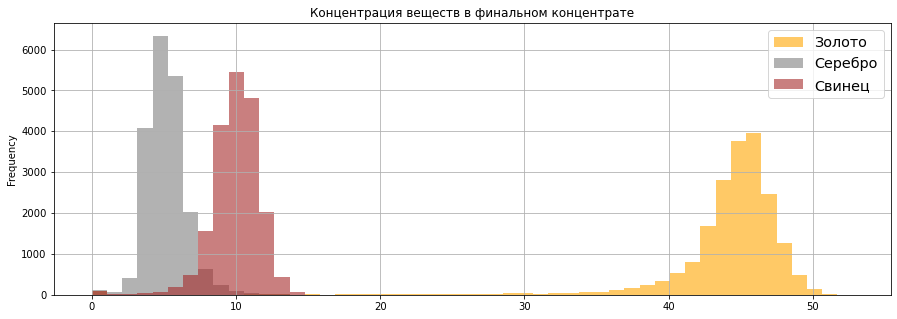

In [49]:
print('Концентрация веществ в финальном концентрате\n')
print(train_data[final_product].sum())

color=['orange', 'grey', 'brown']
full_data[final_product].plot(kind='hist',
                              title='Концентрация веществ в финальном концентрате',
                              bins=50,
                              grid=True,
                              figsize=(15,5),
                              alpha=0.6,
                              color=color
                             )

plt.legend(['Золото', 'Серебро', 'Свинец'], fontsize='x-large')

<div class="alert alert-block alert-info">

**Вывод**

 - До начала процесса в сырье менее всего свинца и более всего золота и серебра (на одном уровне).
 - После этапа флотации свинец вновь на последнем месте по концентрации, серебро на втором, а золото на первом.
 - На распредлении концентрации металлов после окончания процесса сильно заметен отрыв золота; свинец чуть повышает свою концентрацию, серебро же напротив уменьшает почти до минимума.

На гистограммах (особенно на черновом концентрате) замечены аномальные значения в районе нуля (в основном у свинца) - уберем их.

**Концентрация веществ в сырье**

In [50]:
# посмотрим на распределение значений 
print(full_data['rougher.input.feed_pb'].value_counts())

# удалим аномальные
full_data = full_data.loc[full_data['rougher.input.feed_pb']>0.2]

1.533528    33
1.019183    19
0.125889    15
1.352495    14
3.909912    11
            ..
2.955855     1
2.779557     1
2.593901     1
2.719459     1
3.875727     1
Name: rougher.input.feed_pb, Length: 19300, dtype: int64


In [51]:
# проверим результат
print(full_data['rougher.input.feed_pb'].value_counts())

1.533528    33
1.019183    19
1.352495    14
3.909912    11
4.226074     6
            ..
2.779557     1
2.593901     1
2.719459     1
2.775837     1
3.875727     1
Name: rougher.input.feed_pb, Length: 19294, dtype: int64


**Концентрация веществ в черновом концентрате**

In [52]:
# посмотрим на распределение значений 
print(full_data['rougher.output.concentrate_pb'].value_counts())

# удалим аномальные
full_data = full_data.loc[full_data['rougher.output.concentrate_pb']!=0]

0.000000     394
13.077148     11
8.452148       8
10.452148      7
9.764648       6
            ... 
6.506442       1
6.390072       1
6.217873       1
6.104143       1
10.702148      1
Name: rougher.output.concentrate_pb, Length: 18933, dtype: int64


In [53]:
# проверим результат 
print(full_data['rougher.output.concentrate_pb'].value_counts())

13.077148    11
8.452148      8
10.452148     7
7.944824      6
8.264648      6
             ..
6.506442      1
6.390072      1
6.217873      1
6.104143      1
10.702148     1
Name: rougher.output.concentrate_pb, Length: 18932, dtype: int64


**Концентрация веществ в финальном концентрате**

In [54]:
# удалим аномальные значения

full_data = full_data.loc[full_data['final.output.concentrate_ag']!=0]
full_data = full_data.loc[full_data['final.output.concentrate_pb']!=0]

In [55]:
# проверим результат серебро 
print(full_data['final.output.concentrate_ag'].value_counts())

5.925380     11
3.554558      7
3.572025      6
5.955403      5
3.636006      3
             ..
6.029688      1
10.426819     1
8.148960      1
5.245283      1
3.598375      1
Name: final.output.concentrate_ag, Length: 18891, dtype: int64


In [56]:
# проверим результат свинец
print(full_data['final.output.concentrate_pb'].value_counts())

14.764648    11
11.452148     8
12.202148     7
12.577148     6
11.514648     4
             ..
3.214494      1
9.185671      1
7.346850      1
8.176835      1
11.737832     1
Name: final.output.concentrate_pb, Length: 18861, dtype: int64


# Построение модели

## Функция качества 

Напишем функцию для метрики качества sMAPE.

In [57]:
def my_smape(y_true, y_pred): 
    
    y_pred = [p if p!=0 else 0.0000001 for p in y_pred]    # проверка для деления на 0 
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    smape = sum(abs(y_true-y_pred) / ((abs(y_true) + abs(y_pred)) / 2))
        
    return smape*100/len(y_true)

In [58]:
def final_smape(smape_rougher, smape_final):
    
    final_smape = 0.25*smape_rougher + 0.75*smape_final    
    return final_smape

## Подготовка к обучению

Для оценки итоговой метрики качества нам нужны колонки ['rougher.output.recovery'] и ['final.output.recovery']. 
Используем их как целевой признак.

Построим 2 модели - для предсказания этих целевых признаков двумя этапами. Учтем, что эффективность флотации не учитывает последующие этапы - первичную и вторичную очистку, поэтому для обучения и предсказания этого целевого признака откорректируем датасет.

**Флотация**

In [59]:
rougher_row = [] # список хранит названия колонок флотации

for row in list(train_data.iloc[:0]):
    if 'rougher' in row:
        rougher_row.append(row)
        
train_rougher = train_data[rougher_row]  # сохраняем колонки флотации обучающего набора в отдельный датасет      

In [60]:
rougher_row = []

for row in list(test_data.iloc[:0]):
    if 'rougher' in row:
        rougher_row.append(row)
        
test_rougher = test_data[rougher_row]   # сохраняем колонки флотации тестового набора в отдельный датасет      

In [61]:
# разделим флотацию на целевые признаки и признаки обучения

X_rougher = train_rougher.drop(['rougher.output.recovery'], axis=1)
y_rougher = train_rougher['rougher.output.recovery']

In [62]:
# проверим признаки обучения

X_rougher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate  14149 non-null  float64
 1   rougher.calculation.au_pb_ratio                14149 non-null  float64
 2   rougher.input.feed_ag                          14149 non-null  float64
 3   rougher.input.feed_pb                          14149 non-null  float64
 4   rougher.input.feed_rate                        14149 non-null  float64
 5   rougher.input.feed_size                        14149 non-null  float64
 6   rougher.input.feed_au                          14149 non-null  float64
 7   rougher.input.floatbank10_sulfate              14149 non-null  float64
 8   rougher.input.floatbank10_xanthate             14149 non-null  float64
 9   rougher.input.floatbank11_sulfate              141

**Размер датасетов**

Учтем, что для того, чтобы использовать обученную модель на тесте features обучающей выборки должны совпадать с features тестовой выборки

In [63]:
print('Колонки тестовой флотации -', test_rougher.shape[1])
print('Колонки обучающего набора -', X_rougher.shape[1])

Колонки тестовой флотации - 13
Колонки обучающего набора - 25


Необходимо убрать колонки обучающего набора, не совпадающие с тестовым - в идеальном варианте число колонок должно стать равным, т.к удалять колонки из тестового набора данных 

In [64]:
delete_train = [] # список уникальных колонок обучающего набора этапа флотации

for row in list(X_rougher.iloc[:0]):
    if row not in list(test_rougher.iloc[:0]):
        delete_train.append(row)
        
print('Количество уникальных колонок X_rougher -', len(delete_train))  

Количество уникальных колонок X_rougher - 12


In [65]:
# удалим колонки

X_rougher = X_rougher.drop(columns=delete_train, axis=1)

In [66]:
# проверим совпадение размеров

print('Колонки тестовой флотации -', test_rougher.shape[1])
print('Колонки обучающего набора -', X_rougher.shape[1])

Колонки тестовой флотации - 13
Колонки обучающего набора - 13


**Финальный результат**

In [67]:
# разделим на целевые признаки и признаки обучения

X_final = train_data.drop(['final.output.recovery'], axis=1)
y_final = train_data['final.output.recovery']

Не забудем о необходимости совпадения размеров датасетов

In [68]:
print('Колонки тестового набора -', test_data.shape[1])
print('Колонки обучающего набора -', X_final.shape[1])

Колонки тестового набора - 41
Колонки обучающего набора - 69


In [69]:
delete_train = [] # список уникальных колонок обучающего набора 

for row in list(X_final.iloc[:0]):
    if row not in list(test_data.iloc[:0]):
        delete_train.append(row)
        
print('Количество уникальных колонок X_final -', len(delete_train))         

Количество уникальных колонок X_final - 32


In [70]:
# удаляем колонки

X_final = X_final.drop(columns=delete_train, axis=1)

In [71]:
delete_test = [] # список уникальных колонок тестового набора этапа флотации

for row in list(test_data.iloc[:0]):
    if row not in list(X_final.iloc[:0]):
        delete_test.append(row)
        
print('Количество уникальных колонок тестового набора -', len(delete_test)) 

Количество уникальных колонок тестового набора - 4


In [72]:
# оценим, какие уникальные колонки тестовых данных выделяются

delete_test

['date',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_level']

In [73]:
# удалим колонки, кроме date, и сохраним полученный набор в новую переменную test_final

test_final = test_data.drop(columns=['primary_cleaner.state.floatbank8_a_level',
                                     'primary_cleaner.state.floatbank8_b_level',
                                     'primary_cleaner.state.floatbank8_c_level'
                                    ], axis=1)

In [74]:
# проверим совпадение размеров

print('Колонки тестового набора -', test_final.shape[1])
print('Колонки обучающего набора -', X_final.shape[1])

Колонки тестового набора - 38
Колонки обучающего набора - 37


## Обучение  

Напишем функцию, которая позволит нам пройтись по моделям, используя кросс-валидацию, и выведет нужные нам метрики качества для вывода лучшей модели.

In [75]:
# зададим модели

lr = LinearRegression()
rfr = RandomForestRegressor()
dtr = DecisionTreeRegressor()

In [76]:
# скорвертируем свою функцию для использования ее в кросс-валидации
# не забудем, что для нашей метрики лучшим реузльтатом будет самый низкий показатель

my_func = make_scorer(my_smape, greater_is_better=False)

In [77]:
# напишем функцию для кросс-валидационного обучения
# функция примет модель, ее параметры, а выведет лучшие параметры модели и лучшую метрику Smape 

def training(model, params, X, y):  
    
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring=my_func)
    grid.fit(X, y)
    print('Модель', model)
    print('Лучшие параметры модели', grid.best_params_)
    print('Лучшая метрика модели', abs(grid.best_score_))   

**Обучим на данных по этапу флотации**

Целевая метрика - 'rougher.output.recovery'

In [78]:
training(lr, {}, X_rougher, y_rougher)

Модель LinearRegression()
Лучшие параметры модели {}
Лучшая метрика модели 13.090090981865254


In [79]:
dtr_parametrs = {'max_depth': range (1,53,2),
                 'min_samples_leaf': range (1,5),
                 'min_samples_split': range (2,8,2) 
                }

training(dtr, dtr_parametrs, X_rougher, y_rougher)

Модель DecisionTreeRegressor()
Лучшие параметры модели {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4}
Лучшая метрика модели 11.79814822227176


In [80]:
rfr_parametrs = {'n_estimators': range (10, 50, 10),
             'max_depth': range (1,5,2),
             'min_samples_leaf': range (1,3),
             'min_samples_split': range (2,8,2) 
            }

training(rfr, rfr_parametrs, X_rougher, y_rougher)

Модель RandomForestRegressor()
Лучшие параметры модели {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
Лучшая метрика модели 11.24659549896933


**Обучим на данных всего процесса**

Целевая метрика - 'final.output.recovery'

In [81]:
training(lr, {}, X_final, y_final)

Модель LinearRegression()
Лучшие параметры модели {}
Лучшая метрика модели 11.364078266891738


In [82]:
# скорректируем диапазон подбора параметров, исходя из предыдущего обучения

dtr_parametrs = {'max_depth': range (1,6,2),
                 'min_samples_leaf': range (1,5),
                 'min_samples_split': range (2,6,2) 
                }

training(dtr, dtr_parametrs, X_final, y_final)

Модель DecisionTreeRegressor()
Лучшие параметры модели {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4}
Лучшая метрика модели 10.7607034753383


In [83]:
rfr_parametrs = {'n_estimators': range (10, 30, 10),
             'max_depth': range (1,5,2),
             'min_samples_leaf': range (1,3),
             'min_samples_split': range (2,4,2) 
            }

training(rfr, rfr_parametrs, X_final, y_final)

Модель RandomForestRegressor()
Лучшие параметры модели {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
Лучшая метрика модели 10.305919765519727


**Вывод**

Лучший Smape на обоих этапах показал Случайный лес и параметрами 'n_estimators': 20, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2. Его будем использовать для теста

## Тест

Используем функцию df.merge для отбора нужных нам строк целевых признаков 'rougher.output.recovery' и 'final.output.recovery'. Добавим только те значения колонок, у которых дата совпадает с датой тестовой выборки.

In [84]:
# создаем таблицу, куда добавяляем только не значения целевых признаков, которые совпадают по дате с тестовой выборкой

test = test_final.merge(full_data[['date', 'rougher.output.recovery', 'final.output.recovery']] , on='date', how='inner')

In [85]:
# проверим результат

test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1400.102998,-499.485144,13.128569,5.636710,489.793655,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1396.151033,-500.416324,13.036280,5.526065,490.104534,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.075709,-499.715479,13.138412,5.426561,489.617969,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1400.129303,-501.038738,12.400507,5.114758,476.618130,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1402.172226,-499.374053,11.327427,4.767383,488.248117,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [86]:
# сохраним целевые признаки в отдельные переменные

y_rougher_test = test['rougher.output.recovery']
y_final_test = test['final.output.recovery']

# из тестового набора данных удалим колонку с датой

test_final = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

Проведем тест на модели, показавшей лучшие результаты на кросс-валидации.

RandomForestRegressor - 'n_estimators': 20, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2.

<div class="alert alert-block alert-warning">
    
Так как на этапе построения диаграмм суммарной концентрации веществ были удалены аномальные значения длина массива уменьшилась - нужна дополнительная проверка, которая приравнивает ранее полученный массив для этапа флотации с длиной целевых метрик

In [87]:
test_rougher = test_rougher[:len(test_final)]

In [88]:
# обучим модель и выведем предсказания этапа флотации
best_rfr = RandomForestRegressor(n_estimators=20, max_depth=3)
best_rfr.fit(X_rougher[:len(test_rougher)], y_rougher[:len(test_rougher)])
test_rougher_pred = best_rfr.predict(test_rougher)

# обучим модель и выведем предсказания всего процесса
best_rfr.fit(X_final, y_final)
test_final_pred = best_rfr.predict(test_final)

# выведем нашу целевую метрику каждого целевого признака и общую
smape_rougher = my_smape(y_rougher_test, test_rougher_pred)
smape_final = my_smape(y_final_test, test_final_pred)
smape = final_smape(smape_rougher, smape_final)

In [89]:
print('Итоги теста модели')
print('sMAPE этапа флотации', smape_rougher)
print('sMAPE всего процесса', smape_final)
print('Итоговый sMAPE', smape)

Итоги теста модели
sMAPE этапа флотации 8.137969606662699
sMAPE всего процесса 7.8673819874000746
Итоговый sMAPE 7.9350288922157315


# Общий вывод


<div class="alert alert-block alert-danger">

 - Были проверены расчеты эффективности - эффективность флотации расчитана правильно - медиана и статистики полученных значений равны значениям таблицы (погрешность минимальна); средняя абсолютная ошибка также минимальна (формально равна нулю)

 - Распределение гранул в обеих выборках имеет сходный характер - поэтому при обучении и тесте выводы не должны отличаться - оценка модели будет верной.
 
Оценка гистограмм изменения концентрации металлов привела к следующим выводам:    
 - Вполне ожидаемо концентрация золота стабильно увеличивается с каждым этапом обработки - от минимума, сосредоточенного в районе до 10 ед, до максимума - от 40 до 50 ед.
 - особенность серебра - после флотации этот металл повышает свою концентрацию почти до 15 ед, но затем стабильно снижает ее вплоть до 3-7 ед.
 - Свинец показывает в общем сходную динамику с золотом - его концентрация повышается, но не так выраженно и в более скромном масштабе - его максимум сосредоточен в районе 10 ед. Кроме того, повышение концентрации наблюдается только до этапа первичной очистки - затем она перестает расти. 

По суммарной концентрации веществ на разных стадиях можно сделать следующие выводы:
 - До начала процесса в сырье менее всего свинца и более всего золота и серебра (на одном уровне).
 - После этапа флотации свинец вновь на последнем месте по концентрации, серебро на втором, а золото на первом.
 - На распредлении концентрации металлов после окончания процесса сильно заметен отрыв золота; свинец чуть повышает свою концентрацию, серебро же напротив уменьшает почти до минимума
 - Замечены и удалены аномальные значения в районе нуля
 
Для этапа обучения модели стоит отметить:
 - Лучший результат качества показала модель Случайного Леса - причем на тесте она показала результат почти в 2 раза лучше, чем на обучении - итоговый показатель теста **7.935** против **10.54** обучения.